In [25]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


# Libraries to be used

In [26]:
import tensorflow as tf
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [27]:
from sklearn.model_selection import train_test_split

# Load Data

In [28]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
# normalising the dimensions of images to increase the performance of cnn

In [29]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images, test_images = train_images / 255.0, test_images / 255.0

# Use only 60% of the dataset
train_images, train_labels = train_images[:int(0.1 * len(train_images))], train_labels[:int(0.1 * len(train_labels))]

# Convert images to 3-channel (RGB) and resize to 224x224 for VGG16
def preprocess_images(images):
    images = tf.expand_dims(images, axis=-1)  # Add channel dimension
    images = tf.image.grayscale_to_rgb(images)  # Convert to RGB
    images = tf.image.resize(images, [224, 224])  # Resize to 224x224
    return images.numpy()

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)

# Split train data into train and validation sets (80-20 split of 60% dataset)
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [30]:
random_index = np.random.randint(0,len(train_images))
random_image = train_images[random_index]
random_label = train_labels[random_index]

# EDA

In [31]:
temp=np.argmax(train_labels, axis=1)
d={}
for i in range(10):
    d[i]=0
for q in temp:
    d[q]+=1
print(d)
#balanced dataset

{0: 592, 1: 671, 2: 581, 3: 608, 4: 623, 5: 514, 6: 608, 7: 651, 8: 551, 9: 601}


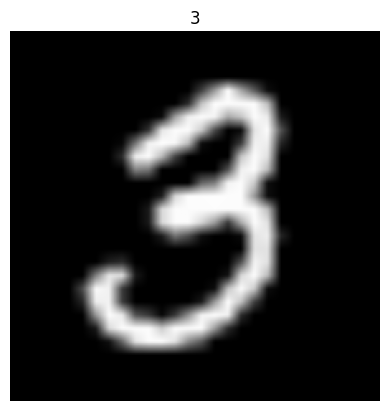

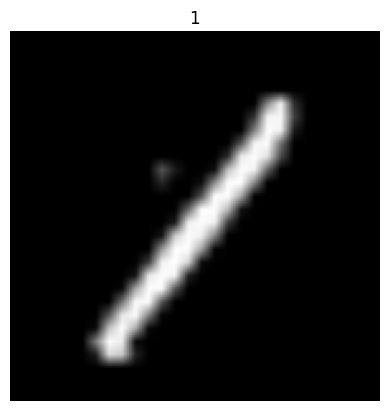

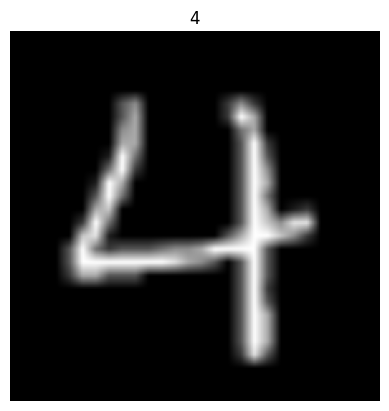

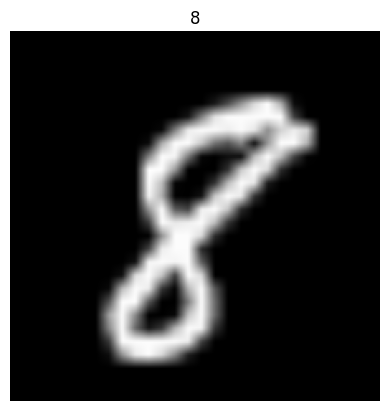

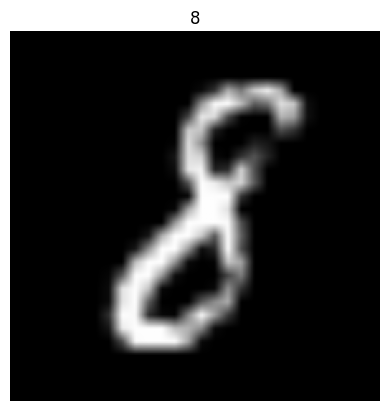

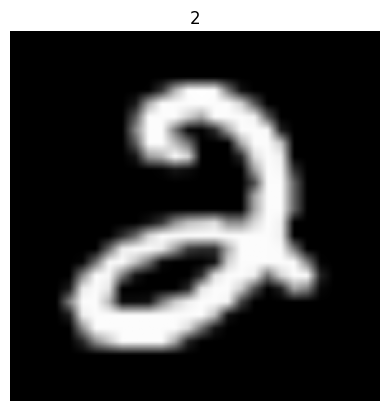

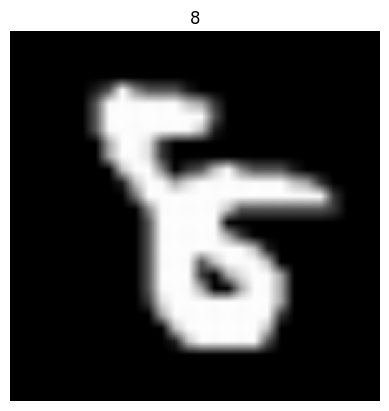

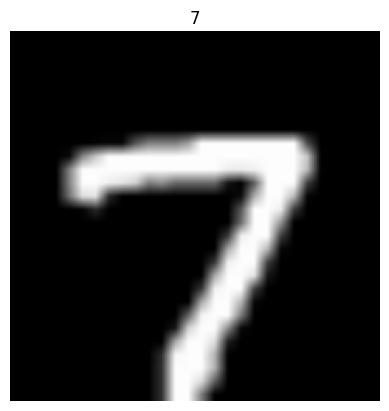

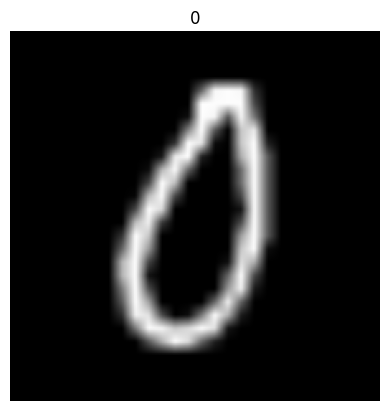

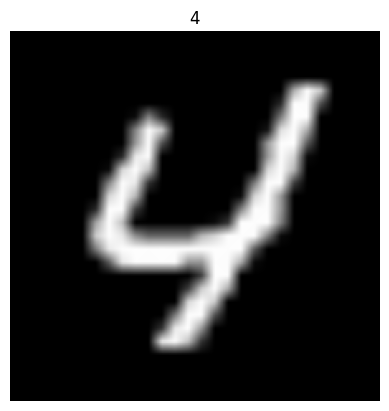

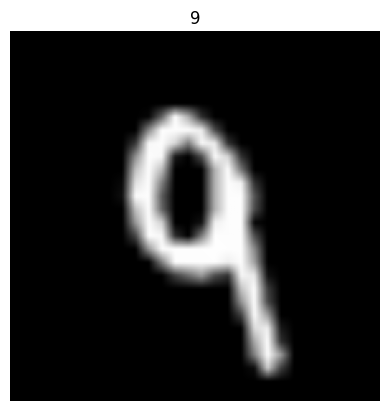

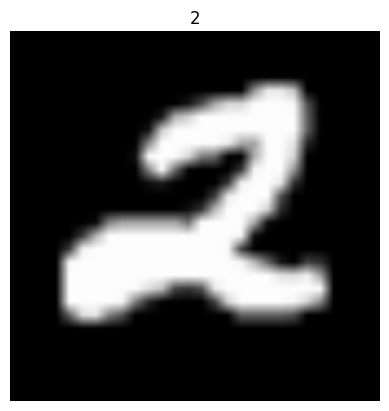

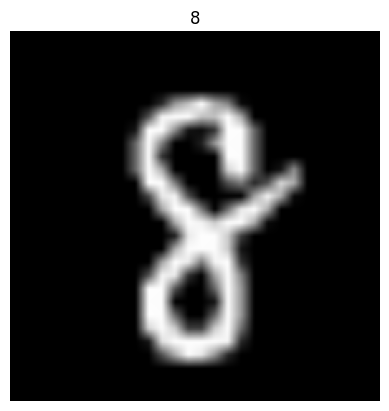

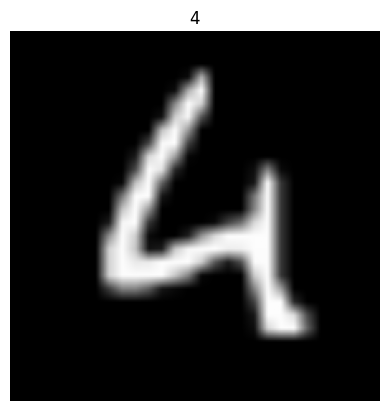

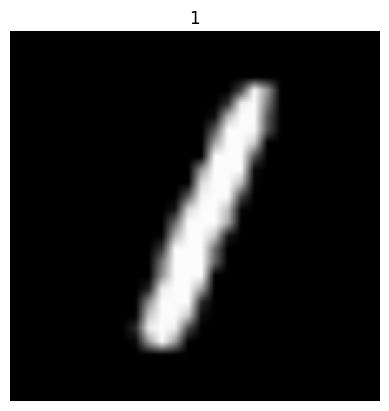

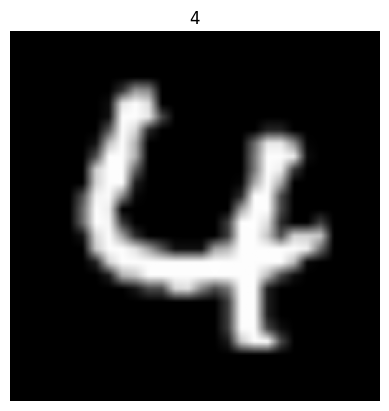

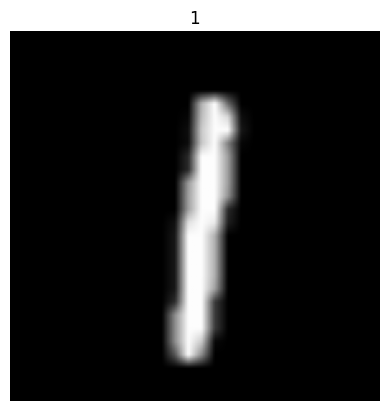

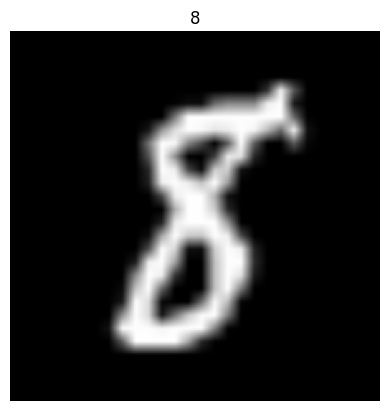

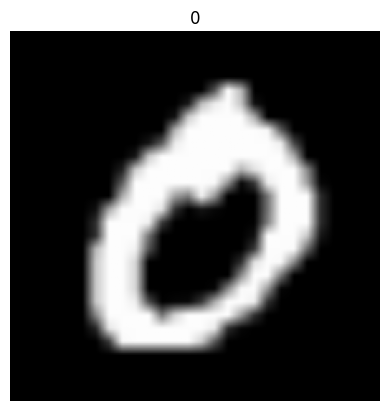

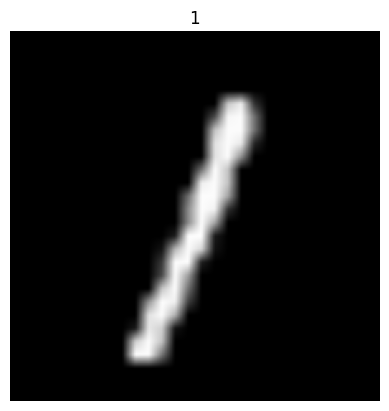

In [32]:
for i in range(20):
    random_index = np.random.randint(0, len(train_images))
    random_image = train_images[random_index]
    random_label = train_labels[random_index]

    plt.imshow(random_image, cmap='gray')  # Use 'gray' for MNIST images
    plt.axis('off')
    plt.title(np.argmax(random_label))  # Convert one-hot label back to a class index
    plt.show()

In [33]:
random_image.shape

(224, 224, 3)

In [34]:
labels = str(list(range(0,10)))
labels

'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]'

In [35]:
num_samples = 12
random_indices = np.random.choice(train_images.shape[0], num_samples, replace=False)
sample_images = train_images[random_indices]
sample_labels = train_labels[random_indices]

In [36]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Deep learning: VGG16 Network

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 base layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom layers on top of VGG16
x = Flatten()(vgg_base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)  # 10 classes for MNIST

# Create final model
model = Model(inputs=vgg_base.input, outputs=output)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Train the model without using ImageDataGenerator
##change to true if train CNN
if False:
    history = model.fit(
        X_train, y_train,  # Directly use the training data
        validation_data=(X_val, y_val),  # Directly use the validation data
        epochs=10,
        batch_size=32  # Set batch size here
    )

# Unsupervised method: TSNE+GMM

In [39]:
from sklearn.manifold import Isomap, TSNE
from sklearn.decomposition import PCA
# Clustering
from sklearn.mixture import GaussianMixture
import timeit



print(X_train.shape)
X_train_tsne=X_train.reshape(4800,-1)
print(X_train_tsne.shape)
y_train_label=np.argmax(y_train,axis=1)
y_val_label=np.argmax(y_val,axis=1)

(4800, 224, 224, 3)
(4800, 150528)


In [40]:
if True:#change to true if you want to run GMM
    start = timeit.default_timer()
    tsne = TSNE(n_components=3,
                n_jobs=-1)
    digits_proj = tsne.fit_transform(X_train_tsne)
    gmm = GaussianMixture(
        n_components=10)
    clusters = gmm.fit_predict(digits_proj)
    #Your statements here
    
    stop = timeit.default_timer()
    
    print('Time: ', stop - start) 
    voter=np.zeros(shape=(10,10))
    
    for i in range(len(clusters)):
        #print(clusters[i],y_train_label[i])
        voter[clusters[i]][y_train_label[i]]+=1
    print(voter)
    trans=np.argmax(voter,axis=1)
    correct=0
    for i in range(len(clusters)):
        if y_train_label[i]==trans[clusters[i]]:
            correct+=1
    print(correct/len(clusters))

Time:  157.3312752239999
[[  0.   0.   1.   0. 267.   0.   0.  26.   2. 264.]
 [  0. 219.   7.   3.   4.   1.   1.   4.   4.   0.]
 [476.   0.   0.   1.   0.   1.   3.   0.   4.   5.]
 [  1. 308.   2.   3.   4.   1.   1.   5.   3.   1.]
 [  0.   2.   9.   3.   1.   0.   0. 441.   1.  10.]
 [  5.   1.   5.  13.   3. 247.  12.   1. 358.   0.]
 [  0.   3. 430.   2.   1.   1.   0.   3.   2.   0.]
 [  1.   1.   4.   2.   7.   4. 471.   0.   2.   1.]
 [  1.   1.   7. 450.   0. 155.   1.   0.  59.   7.]
 [  0.   2.   1.   4. 217.   7.   0.  29.   5. 185.]]
0.7577083333333333


# Unsupervised method: reduce training data

In [41]:
start = timeit.default_timer()

X_train_tsne2=X_train_tsne[:2400][:]
y_train_label2=np.argmax(y_train,axis=1)[:2400]
print(X_train_tsne2.shape)
tsne2 = TSNE(n_components=3,
            n_jobs=-1)
digits_proj2 = tsne2.fit_transform(X_train_tsne2)
gmm2 = GaussianMixture(
    n_components=10)
clusters2 = gmm2.fit_predict(digits_proj2)
#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start) 

voter2=np.zeros(shape=(10,10))

for i in range(len(clusters2)):
    #print(clusters[i],y_train_label[i])
    voter2[clusters2[i]][y_train_label2[i]]+=1
print(voter2)
trans2=np.argmax(voter2,axis=1)
correct2=0
for i in range(len(clusters2)):
    if y_train_label2[i]==trans2[clusters2[i]]:
        correct2+=1
print(correct2/len(clusters2))

(2400, 150528)
Time:  56.688194474000284
[[  1. 147.   3.   0.   0.   1.   0.   5.   1.   0.]
 [  0.   1.   5. 223.   0.  28.   0.   0.   8.   3.]
 [  0.   0.   1.   2.   6.   7. 241.   0.   4.   0.]
 [  1.   2.   1.   4. 244.   7.   2.  13.   3. 182.]
 [  0.   1. 219.   6.   0.   0.   0.   3.   5.   0.]
 [  0. 110.   3.   2.   2.   0.   0.   3.   2.   0.]
 [  0.   0.   0.   7.   0.   4.   0.   0. 196.   0.]
 [  0.   2.   8.   1.  12.   0.   0. 217.   0.  33.]
 [  0.   0.   4.   7.   0. 164.   4.   1.   2.   0.]
 [232.   0.   0.   0.   0.   0.   2.   0.   1.   1.]]
0.8304166666666667


# Supervised Machine learning: SVM 

In [42]:
from sklearn import svm
from sklearn import metrics
svm_linear = svm.SVC(kernel='linear')
print("Full Features: ",X_train_tsne.shape)
print(X_val.shape)
y_val_label=np.argmax(y_val,axis=1)



Full Features:  (4800, 150528)
(1200, 224, 224, 3)


In [43]:
# fit
if False: #change to True if you want to apply SVM on raw data
    svm_linear.fit(X_train_tsne, y_train_label)
    predictions_SVM = svm_linear.predict(X_val.reshape(1200,-1))
    correct=0
    for i in range(len(predictions_SVM)):
        if(predictions_SVM[i]==y_val_label[i]):
            correct+=1
    print(correct/len(predictions_SVM))

# Supervised Machine learning: SVM with PCA dimension reduction

In [44]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 20)
pca.fit(X_train_tsne)
X_train_pca = pca.transform(X_train_tsne)
print(X_train_pca.shape)

(4800, 20)


In [45]:
from sklearn import svm
svm_linear2 = svm.SVC(kernel='linear')
start = timeit.default_timer()
# fit
svm_linear2.fit(X_train_pca, y_train_label)

print("train_complete")
X_val_pca = pca.transform(X_val.reshape(1200,-1))
print(X_val_pca.shape)
predictions_pca = svm_linear2.predict(X_val_pca)

correct=0
for i in range(len(predictions_pca)):
    if(predictions_pca[i]==y_val_label[i]):
        correct+=1
print(correct/len(predictions_pca))

stop = timeit.default_timer()
print('Time: ', stop - start) 

train_complete
(1200, 20)
0.9083333333333333
Time:  13.015603397999712


# Supervised Machine learning: SVM hyperparameter tuning

In [46]:
from sklearn.model_selection import GridSearchCV
parameters = {'C': [1, 5, 10], 
          'gamma': [0.001, 0.01, 1]}
model_SVM_GS = svm.SVC()
grid = GridSearchCV(estimator=model_SVM_GS, param_grid=parameters)
grid.fit(X_train_pca, y_train_label)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'gamma': [0.001, 0.01, 1]})
0.9441666666666666
SVC(C=5, gamma=0.001)


In [47]:
predictions_grid = grid.predict(X_val_pca)

correct=0
for i in range(len(predictions_grid)):
    if(predictions_grid[i]==y_val_label[i]):
        correct+=1
print(correct/len(predictions_grid))


0.9483333333333334


# Deep learning: other analysis

In [48]:

from tensorflow.keras.optimizers import Adagrad

In [49]:
# Modeling
model.compile(optimizer='Adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,370 (68.39 MB)

 Trainable params: 3,212,682 (12.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
loss,accuracy = model.evaluate(X_train,y_train)
print(f"The model accuracy is : {accuracy} \n the model loss : {loss}")

I0000 00:00:1733920451.204469     102 service.cc:145] XLA service 0x7dc46000cf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733920451.204534     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733920451.204540     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/150 ━━━━━━━━━━━━━━━━━━━━ 36:33 15s/step - accuracy: 0.0625 - loss: 2.5141

I0000 00:00:1733920465.297473     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 124ms/step - accuracy: 0.0936 - loss: 2.3835
The model accuracy is : 0.10104166716337204 
 the model loss : 2.377922773361206


In [52]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Predict the class probabilities for the test dataset
predictions = model.predict(X_val)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_val, axis=1)  # Convert one-hot to class indices

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
true_labels = np.argmax(y_val, axis=1)  # Convert one-hot encoded to class indices
predicted_labels = np.argmax(predictions, axis=1)  # Already converting probabilities to class indices
correct=0
for i in range(len(true_labels)):
    if true_labels[i]==predicted_labels[i]:
        correct+=1
print(correct/len(true_labels))
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()